# Lecture 10: Conjugate Gradient Methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
import utils as utils
from fractions import Fraction
from conjugate import ConjugateGradient

from func import Func
from IPython.display import display, HTML

# Inline plotting
%matplotlib inline

# Make sympy print pretty math expressions
sy.init_printing()

# Load custom stylesheet
utils.load_custom_styles()

---
## Questions
- What does this mean: "If Newton's method converges, it has a quadratic order of convergence."? [CZ. p193]


---
## Definiteness of Matrices


Here are the definitions. Let $\mathbf{x}$ be non-zero vector:

1. A matrix $A$ is positive definite if $\mathbf{x}^T A \mathbf{x} > 0$ for all vectors $\mathbf{x} \not = \mathbf{0}$
1. A matrix $A$ is positive semi-definite if $\mathbf{x}^T A \mathbf{x} \geq 0$ for all vectors $\mathbf{x} \not = \mathbf{0}$
3. A matrix $A$ is negative definite if $\mathbf{x}^T A \mathbf{x} < 0$ for all vectors $\mathbf{x} \not = \mathbf{0}$
4. A matrix $A$ is negative semi-definite if $\mathbf{x}^T A \mathbf{x} \leq 0$ for all vectors $\mathbf{x} \not = \mathbf{0}$

One way to tell if a matrix is positive definite is to calculate the eigenvalues and just check to see if they’re all positive. However, computing the eigenvalues for large matrices may be difficult.

<img src="figures/lecture-10/definiteness-intuition.png" width="400" />


Graphically, positive-definiteness describes the bowl shape of a paraboloid.

<img src="figures/lecture-10/pos-neg-definite.png" width="600" />


<img src="figures/lecture-10/semi-definite-matrices.png" width="600" />


Finally, we have the indefinte matrix where $\mathbf{x}^T A \mathbf{x} $ is sometimes zero, positive or negative:

<img src="figures/lecture-10/indefinite-matrix.png" width="500" />












<img src="figures/lecture-10/definiteness-saddle-point.png" width="500" />


---
## Trust Region Algorithm

Trust region algorithm is an algorithm that works like the Newtom algorithm:

1. Create an quadratic approximation $Q(\mathbf{x})$ of $f(\mathbf{x})$ around $\mathbf{x}^{(k)}$ i.e., a polynomial of degree 2. 
2. Define a **Trust Region** around the current point. The trust region is just a circle of radius $\delta_k$ centered at $\mathbf{x}^{(k)}$.
3. Search for the minimum of $Q(\mathbf{x})$ inside the Trust Region. 
4. Let $\mathbf{x}^{(k+1)}$ be the minimum of $Q(\mathbf{x})$ found in the previous step.
5. If $f(\mathbf{x}^{(k+1)}) < f(\mathbf{x}^{(k)})$ then we know that $Q(\mathbf{x})$ is a good approximator of $f(\mathbf{x})$. :
  1. Increase the trust region radius $\delta_k$.
  2. Change $\mathbf{x}^{(k)} = \mathbf{x}^{(k+1)}$ 
6. If $f(\mathbf{x}^{(k+1)}) < f(\mathbf{x}^{(k)})$ but the reduction is not as big as predicted by $Q(\mathbf{x})$, then we do the following:
  1. Do not change the trust region radius $\delta_k$.
  2. Change $\mathbf{x}^{(k)} = \mathbf{x}^{(k+1)}$ 
7. If $f(\mathbf{x}^{(k+1)}) > f(\mathbf{x}^{(k)})$ then we know that $Q(\mathbf{x})$ is no longer a correct approximation of $f(\mathbf{x})$.
  1. Reduce the trust region radius $\delta_k$.
  2. Do not change $\mathbf{x}^{(k)}$
8. Stop the algorithm if $\left \lVert  \mathbf{x}^{(k+1)} - \mathbf{x}^{(k)} \right \rVert $ is too small. Otherwise run another iteration.

Note that the trust region radius becomes very huge at the end of the search.

The figure below illustrates the development of the trust region in each iteration. The red dot represents $\mathbf{x}^{(k)}$ and the red cross represents the minimum of $Q(\mathbf{x})$.

<img src="figures/lecture-10/trust-region-algorithm-steps.png" width="600" />


Basically, at each iteration we are:
1. approximating the underlying function with a quadratic at $\mathbf{x}^{(k)}$, 
2. finding the one single point that is the minimum of our approximation $\mathbf{x}^{(k+1)}$, and only then 
3. seeing what the actual underlying function value is at that point $\mathbf{x}^{(k+1)}$.

---
### Contour plots in matplotlib

How to create contour plots in matplotlib

In [2]:
x1, x2 = sy.symbols('x1, x2')
f = Func(-10*x1**2 + 10*x2**2 + 4*sy.sin(x1 * x2) - 2*x1 + x1**4, (x1, x2))
f

⎡  4        2               2               ⎤
⎣x₁  - 10⋅x₁  - 2⋅x₁ + 10⋅x₂  + 4⋅sin(x₁⋅x₂)⎦

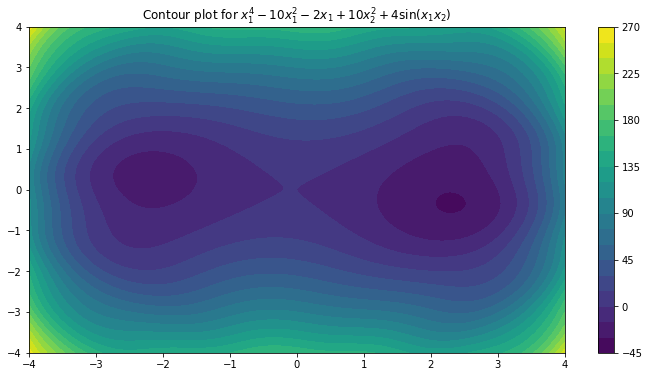

In [3]:
fig, ax = f.plot_contour(x_limit=(-4, 4), levels=20)

---
## Quasi-Newton Methods

Recall that the update rule for the Multivariate Newton method in root finding is given as:

$$
\mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} - \nabla f\left( \mathbf{x}^{(k)} \right)^{-1} f \left( \mathbf{x}^{(k)} \right)
$$
and optimisation algorithm:
$$
\mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} - F \left( \mathbf{x}^{(k)} \right)^{-1} \nabla f \left( \mathbf{x}^{(k)} \right)
$$
where $F$ is the Hessian. 

In general, if the initial point is not sufficiently close to the solution, then Newton's optimisation algorithm may not possess the descent property i.e., $f(\mathbf{x}^{(k+1)}) \not < f(\mathbf{x}^{(k)}) $ for some $k$.

In practice, we may want to may try to guarantee that the algorithm has the descent property by modifying the original algorithm as follows:

$$
\mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} - \alpha_k F(\mathbf{x}^{(k)})^{-1} \nabla f(\mathbf{x}^{(k)})
$$

where$\alpha_k$ is chosen to ensure that $f(\mathbf{x}^{(k+1)}) < f(\mathbf{x}^{(k)}) $. For example, we may choose $\alpha_k = \text{argmin}_{\alpha \geq 0} f\left(\mathbf{x}^{(k)} - \alpha F(\mathbf{x}^{(k)})^{-1} \nabla f(\mathbf{x}^{(k)}) \right) $



<div class="sidenote">
<b>Sidenote:</b> 
Notice how Newton's method is very similar to the steepest descent method:<br>

$$
\mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} - \alpha \nabla f \left( \mathbf{x}^{(k)} \right)
$$
   
In Newton's method, we scale the gradient $\nabla f(\mathbf{x}^{(k)})$ by the Hessian matrix.
</div>


<img src="figures/lecture-10/quasi-newton-intro.png" width="600" />


Computing the inverse of a Hessian requires $O\left(n^3\right)$ with standard techniques. Each iteration of the algorithm can be quite expensive for large $n$.

Quasi-Newton algorithms have the form:

<img src="figures/lecture-10/quasi-newton-method-form.png" width="600" />


<div class="warning">
<b>Warning:</b> 
There are two main differences between the book and the lecture slides. 
<ol>
<li>In the book, the approximation is the inverse of the Hessian i.e., 
 $F^{-1}$ whereas in the lecture, we approximate the Hessian i.e., $F$. Approximating the inverse of the Hessian should be faster than computing the inverse after approximating the Hessian. Why not just approximate the inverse of the Hessian like in the book?</li>
<li>The notation differs; the book uses both $H$ and $B$ to denote the approximation of the inverse of the Hessian. In the slides, $B$ is used to denote the approximation of the Hessian.</li>
</ol>

The rest of this section describes the method in the lecture.
</div>

Quasi-Newton methods avoid computing the Hessian using a procedure analogous to the secant method. We replace the Hessian $F$ with an approximation $B_k$ that is computed for each iteration:

$$
\mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} - B_k^{-1} \nabla f \left( \mathbf{x}^{(k)} \right)
$$

Recall that the secant method approximates derivative of a function $f$ by using two points:

<img src="figures/lecture-10/secant-figure.png" width="600" />




Here is a comparison:

<img src="figures/lecture-10/secant-vs-quasi-newton.png" width="400" />




There are different ways to update $\mathbf{B}_{k+1}$:

<img src="figures/lecture-10/quasi-newton-update-b-rules.png" width="400" />




---
## Conjugate Methods

**Definition:** Let $A$ be an $n \times n$ matrix. Two vectors $\mathbf{d}^{(i)}$ and $\mathbf{d}^{(j)}$ are $A$-conjugate or $A$-orthogonal if their dot product is zero:
$$
\mathbf{d}^{(i)T} A \mathbf{d}^{(j)} = 0
$$

Recall that the matrix-vector multiplication $A \mathbf{d}^{(j)}$ transforms the vector $\mathbf{d}^{(j)}$ into a new coordinate space described by the matrix $A$ if the columns of $A$ are linearly indenpedent. The definition of $A$-conjugate says that the transformed vector  $A \mathbf{d}^{(j)}$ is orthogonal to the other vector $\mathbf{d}^{(i)}$.

<img src="figures/lecture-10/a-conjugate-illustration.png" width="600" />



---
### Intuition

The steepest descent method finds the minimum using a zig-zag approach, where at each iteration the direction is orthogonal to the direction of the previous step. Observe that the algorithms moves in the same direction many times. It would be more efficient to combine all these zigzags into one step for each direction. We don’t want any redundant steps, i.e. each direction should be linearly independent.

<img src="figures/lecture-10/steepest-descent-vs-conjugate-method.png" width="400" />




















Conjugate Gradient Methods come in two algorithms:
1. Conjugate **direction** method: find some good directions that are "conjugate". This method can be computationally expensive.
2. Conjugate **gradient** method: use the gradient to find these "conjugate" directions efficiently. The conjugate directions can be computed incrementally as we go.

---
### Conjugate Direction Algorithm


<img src="figures/lecture-10/conjugate-direction-algorithm-01.png" width="600" />









The gradient of the above quadratic function is:
$$
\nabla f(\mathbf{x}) = Q \mathbf{x} - \mathbf{b}
$$

---

<img src="figures/lecture-10/conjugate-direction-algorithm-02.png" width="600" />




<p class="sidenote"><b>Notice</b> that as input, this algorithm requires a starting point $\mathbf{x}^{(0)}$ and set of vectors $\mathbf{d}^{(0)}, \mathbf{d}^{(1)}, \cdots, \mathbf{d}^{(n-1)}$ that are mutually $Q$-conjugate. 
    </p>

<img src="figures/lecture-10/theorem-10.1.png" width="600" />



Theorem 10.1 tells us that if the matrix $Q$ is an $n \times n$ matrix, then the basic conjugate direction algorithm finds a solution in $n$ iterations.

So for a quadratic function of $n$ variables, the conjugate direction method reaches the solution after $n$ steps. The method also possesses a certain desirable property in the intermediate steps. 

<img src="figures/lecture-10/lemma-10.2.png" width="600" />



where $\mathbf{g}^{(k+1)} = Q \mathbf{x}^{(k+1)} - \mathbf{b} $ is the gradent of the quadratic function $f$.

The conjugate direction algorithm is very effective. However, to use the algorithm, we need to specify the $Q$-conjugate directions. Fortunately, there is a way to generate $Q$-conjugate directions as we perform iterations. The Conjugate Gradient Algorithm incorporates the generation of $Q$-conjugate directions at each step.

---
### Example 10.2

<img src="figures/lecture-10/example-10.2.png" width="600" />


Because $f$ is a quadratic function in two variables, we will find the solution in two steps (according to Theorem 10.1); $\mathbf{x}^{*} = \mathbf{x}^{(2)}$

---
### Conjugate Gradient Algorithm

The conjugate gradient algorithm does not use prespecified conjugate directions, but instead computes the directions as the algorithm progresses.

<img src="figures/lecture-10/conjugate-gradient-algorithm-steps.png" width="600" />



---
### Example 10.3
<img src="figures/lecture-10/example-10.3.png" width="600" />


In [4]:
Q = [[3, 0, 1],
     [0, 4, 2],
     [1, 2, 3]]
b = [3, 0, 1]

# Verify the Q is 
f_ex103 = Func.create_quadratic_half(Q, b)
f_ex103

⎡    2                                        2     ⎤
⎢3⋅x₁                       2             3⋅x₃      ⎥
⎢───── + x₁⋅x₃ - 3⋅x₁ + 2⋅x₂  + 2⋅x₂⋅x₃ + ───── - x₃⎥
⎣  2                                        2       ⎦

In [5]:
cg = ConjugateGradient(f_ex103, Q)
x_star = cg.find_minimum((0, 0, 0))

Stopping since g(k) = [ 0.0000,  0.0000,  0.0000]


$k$,$d^{(k)}$,$\alpha_k$,$x^{(k+1)}$,$g^{(k+1)}$,$\beta_k$
$0$,\begin{bmatrix}3.00000 \\ 0.00000 \\ 1.00000 \\ \end{bmatrix},$0.277778$,\begin{bmatrix}0.83333 \\ 0.00000 \\ 0.27778 \\ \end{bmatrix},\begin{bmatrix}-0.22222 \\ 0.55556 \\ 0.66667 \\ \end{bmatrix},$0.080247$
$1$,\begin{bmatrix}0.46296 \\ -0.55556 \\ -0.58642 \\ \end{bmatrix},$0.218692$,\begin{bmatrix}0.93458 \\ -0.12150 \\ 0.14953 \\ \end{bmatrix},\begin{bmatrix}-0.04673 \\ -0.18692 \\ 0.14019 \\ \end{bmatrix},$0.070749$
$2$,\begin{bmatrix}0.07948 \\ 0.14761 \\ -0.18168 \\ \end{bmatrix},$0.823077$,\begin{bmatrix}1.00000 \\ 0.00000 \\ 0.00000 \\ \end{bmatrix},\begin{bmatrix}0.00000 \\ 0.00000 \\ 0.00000 \\ \end{bmatrix},$0.000000$


In [6]:
x_star

⎡1⎤
⎢ ⎥
⎢0⎥
⎢ ⎥
⎣0⎦

---
### Questions in Class

Why not solve the functions analytically? Because when we get large problems, then we need to store large set of data. Performing matrix operations may take long time.